In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from models.logistic_regression import LogisticRegression
from evaluator.evaluator import Evaluator

In [2]:
DATA_DIR = Path("../data")
FINAL_DATA_DIR = DATA_DIR / "final"

# 0. Load dữ liệu

In [3]:
def load_data(file_path: Path):
    X_train = np.load(file_path / "X_train.npy")
    y_train = np.load(file_path / "y_train.npy")
    X_test = np.load(file_path / "X_test.npy")
    y_test = np.load(file_path / "y_test.npy")

    return X_train, y_train, X_test, y_test


# dữ liệu gốc chưa xử lí cân bằng
original_X_train, original_y_train, original_X_test, original_y_test = load_data(
    FINAL_DATA_DIR / "original"
)

# dữ liệu sau khi under-sampling
under_sample_X_train, under_sample_y_train, under_sample_X_test, under_sample_y_test = (
    load_data(FINAL_DATA_DIR / "under_sampled")
)

# dữ liệu sau khi over-sampling
over_sample_X_train, over_sample_y_train, over_sample_X_test, over_sample_y_test = (
    load_data(FINAL_DATA_DIR / "over_sampled")
)

In [4]:
evaluator = Evaluator(metrics=["accuracy", "precision", "recall", "f1_score"])

In [5]:
# original_model = LogisticRegression(
#     learning_rate=0.01,
#     n_iterations=1000,
# )

# original_model.fit(original_X_train, original_y_train)
# y_pred = original_model.predict(original_X_test)

accuracy: 0.9392
precision: 0.9724
recall: 0.9097
f1_score: 0.9400


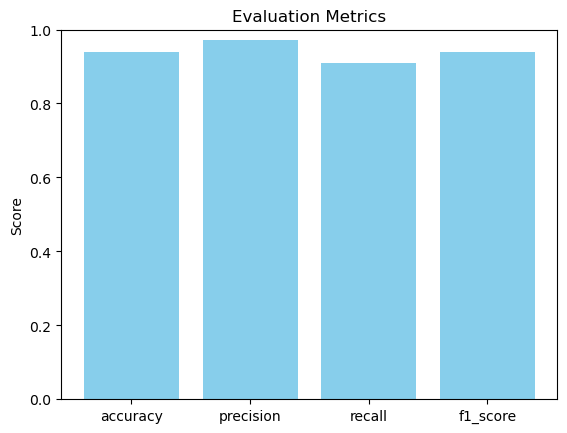

{'accuracy': 0.9391891891891891,
 'precision': 0.9724137931034482,
 'recall': 0.9096774193548387,
 'f1_score': 0.94}

In [6]:
under_sample_model = LogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
)

under_sample_model.fit(under_sample_X_train, under_sample_y_train)

under_sample_y_pred = under_sample_model.predict(under_sample_X_test)

evaluator.evaluate(
    y_true=under_sample_y_test, y_pred=under_sample_y_pred, visualize=True
)

accuracy: 0.9481
precision: 0.0326
recall: 0.9430
f1_score: 0.0630


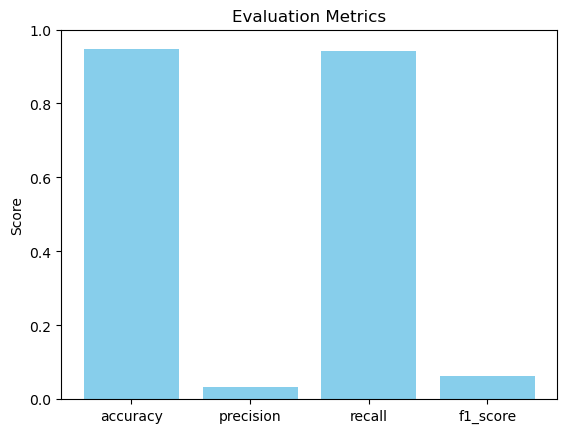

In [7]:
y_pred = under_sample_model.predict(
    original_X_test,
)
results = evaluator.evaluate(y_true=original_y_test, y_pred=y_pred, visualize=True)

accuracy: 0.9481
precision: 0.0326
recall: 0.9430
f1_score: 0.0630
pr_auc: 0.0310


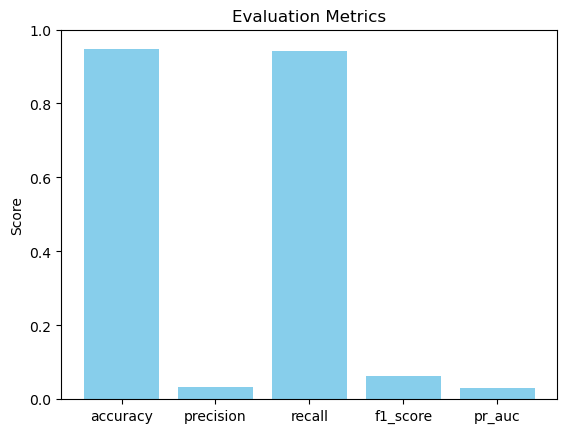

In [ ]:
eval_test = Evaluator(metrics=["accuracy", "precision", "recall", "f1_score"])
results = eval_test.evaluate(
    y_true=original_y_test,
    y_pred=y_pred,
    visualize=True,
)